# Word2Vec SAT

Load the SAT analogies data and the pruned Word2Vec model (based on GoogleNews-vectors-negative300.bin.gz from https://code.google.com/archive/p/word2vec/), but with only the words that appear in the analogies saved.

In [1]:
import numpy
import json
from scipy.spatial.distance import cosine

In [2]:
# Load the model
with open("./vectors.json", "r") as f:
    model = json.load(f)
    
# Load the analogies
with open("./analogies.json", "r") as f:
    analogies = json.load(f)

In [3]:
# Convert the model to use numpy vectors
for key in model:
    model[key] = numpy.array(model[key])

In [4]:
def make_vector(word1, word2):
    try:
        return model[word1] - model[word2]
    except KeyError:
        return None

In [5]:
def cosine_dist(vec1, vec2, digits=3):
    return round(cosine(vec1, vec2), digits)

In [6]:
def print_results(key_words, right_words, wrong_words_list):
    results = []
    
    key_vector = make_vector(*key_words)
    
    right_vector = make_vector(*right_words)
    
    # Fail if we can't find the word in our model
    if key_vector is None or right_vector is None:
        return
    
    results.append((cosine_dist(key_vector, right_vector), right_words, True))

    for wrong_words in wrong_words_list:
        wrong_vector =  make_vector(*wrong_words)
        # Fail if we can't find the word
        if wrong_vector is None:
            return
        results.append((cosine_dist(key_vector, wrong_vector), wrong_words, False))
        
    results.sort()
    
    table = [("{} : {}".format(*key_words), "Distance")]
    for dist, (w1,w2), is_answer in results:
        str_dist = str(dist)
        if is_answer:
            string = "**{} : {}**".format(w1,w2)
            str_dist = "**{}**".format(str_dist)
        else:
            string = "{} : {}".format(w1,w2)

        table.append((string, str_dist))
    
    return table

In [7]:
# Make the tables for the blog, and also figure out how well we did
from tabulate import tabulate

result_place = []
for analogy in analogies:
    key_words = analogy["key"][0]
    right_words = analogy["right"][0]
    wrong_words_list = analogy["wrong"]
    
    table = print_results(key_words, right_words, wrong_words_list)
    if table is not None:
        print tabulate(table, headers="firstrow", tablefmt="pipe")
        print ""
        
        # What spot in this list is the right answer?
        for place,contents  in enumerate(table):
            words = contents[0]
            if '**' in words:
                result_place.append(place)
                break

| paltry : significance   | Distance   |
|:------------------------|:-----------|
| austere : landscape     | 0.803      |
| redundant : discussion  | 0.829      |
| **banal : originality** | **0.861**  |
| oblique : familiarity   | 0.895      |
| opulent : wealth        | 0.984      |

| runner : marathon     | Distance   |
|:----------------------|:-----------|
| referee : tournament  | 0.939      |
| **oarsman : regatta** | **0.945**  |
| martyr : massacre     | 0.948      |
| envoy : embassy       | 0.979      |
| horse : stable        | 1.026      |

| medicine : illness      | Distance   |
|:------------------------|:-----------|
| stimulant : sensitivity | 0.914      |
| **law : anarchy**       | **0.924**  |
| etiquette : discipline  | 1.009      |
| love : treason          | 1.019      |
| hunger : thirst         | 1.157      |

| paltry : significance   | Distance   |
|:------------------------|:-----------|
| austere : landscape     | 0.803      |
| redundant : discussion  |

So how did Word2Vec do? Not so well...

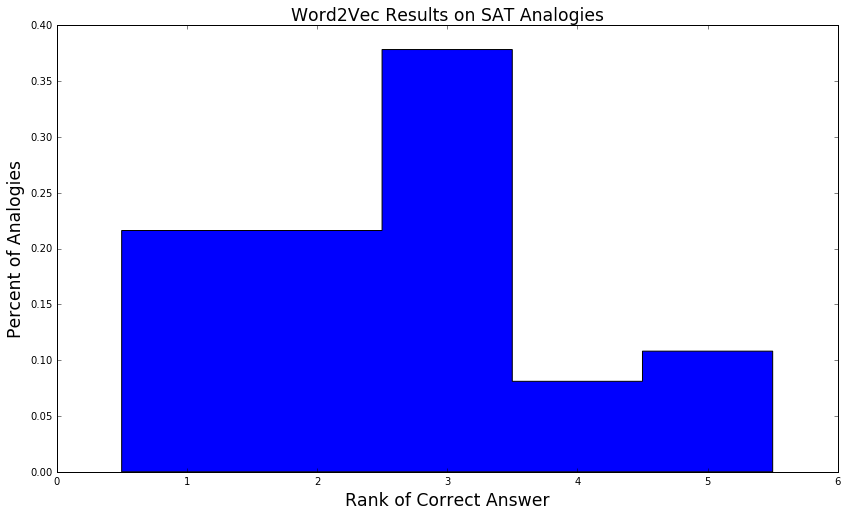

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

# Set the plot size
WIDTH = 14
HEIGHT = 8
plt.figure(figsize=(WIDTH, HEIGHT))

# Plot the histogram
plt.hist(result_place, bins=[1, 2, 3, 4, 5, 6], normed=True, histtype="stepfilled", align="left")

# Set axis labels
FONTSIZE="xx-large"
plt.xlabel('Rank of Correct Answer', fontsize=FONTSIZE)
plt.ylabel('Percent of Analogies', fontsize=FONTSIZE)
plt.title("Word2Vec Results on SAT Analogies", fontsize=FONTSIZE)

# Save and show the figure
plt.savefig("/tmp/analogies_ranking.png")

plt.show()